# Simulation model: 2D advection–diffusion tracer with pulsed heating source

We simulate a simple 2D “atmospheric” field $\,\phi(x,z,t)\,$ (think: tracer concentration or temperature anomaly) on an $(x,z)$ grid, where $x$ is horizontal distance and $z$ is height.

---

### Governing equation (continuous form)

$$
\frac{\partial \phi}{\partial t}
=
-\;u\,\frac{\partial \\phi}{\partial x}
-\;w\,\frac{\partial \phi}{\partial z}
+\;K\,\Delta \phi
+\;A(t)\,S(x,z)
-\;\lambda\,\phi
-\;\lambda_{\text{top}}(z)\,\phi
$$

**Term-by-term meaning**
- **Advection**: $-u\,\phi_x - w\,\phi_z$  
  transports the field with a prescribed mean flow:
  - $u>0$: drift to the **right**
  - $w>0$: drift **upward**
- **Diffusion**: $K\,\Delta\phi$  
  represents mixing/smoothing (subgrid diffusion).
- **Pulsed heating / source**: $A(t)\,S(x,z)$  
  injects tracer in a localized bottom-left patch $S(x,z)$.  
  The amplitude $A(t)$ switches ON/OFF periodically, creating visible “puffs/stripes” that trace the flow.
- **Global decay**: $-\lambda\phi$  
  removes tracer everywhere, preventing unbounded growth.
- **Top sponge loss**: $-\lambda_{\text{top}}(z)\phi$  
  additional damping near the model top (energy/tracer leak upward), ensuring long-term equilibrium.

---

### Boundary conditions

- **Periodic in $x$**: material leaving the right boundary re-enters from the left (wrap-around).
- **No-flux / reflective in $z$**: used for the finite-difference stencils at top and bottom.

---

### Numerics

- Spatial derivatives are approximated with finite differences:
  - **Upwind** for advection (stable transport)
  - **Centered Laplacian** for diffusion
- Time integration uses **RK4** (4th-order Runge–Kutta) with a conservative time step based on CFL-like constraints.

---

### Goal of this setup

This configuration produces a clean, interpretable dynamical system where a localized, time-varying source generates a tracer plume that is advected right/up, mixed by diffusion, and damped (especially near the top). This makes it ideal for later steps:
- defining observation operators (radiosondes + satellite-like integrals),
- building data assimilation cost functions,
- training neural networks to emulate analysis increments.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D tracer/heating plume: pulsing bottom-left source,
# advected right+up, periodic in x (wraparound),
# RK4 time integration
# ============================================================

# ----------------------------
# Grid
# ----------------------------
nx, nz = 130, 50
Lx, Lz = 1300.0, 360.0  # meters
x = np.linspace(0.0, Lx, nx)
z = np.linspace(0.0, Lz, nz)
dx = x[1] - x[0]
dz = z[1] - z[0]
X, Z = np.meshgrid(x, z)

# ----------------------------
# Mean flow: right + upward
# ----------------------------
u = 2.6   # m/s (right)
w = 0.55  # m/s (up)

# ----------------------------
# Diffusion and decay
# ----------------------------
K = 12.0            # m^2/s
tau_decay = 800.0   # seconds (prevents runaway / makes "trace" finite)
lam = 1.0 / tau_decay

# --- top sponge (energy loss through the top) ---
# stronger damping near the top boundary; ~0 near the bottom
z_top = 0.80 * Lz         # sponge starts at 80% of domain height
tau_top = 100.0           # seconds: damping time at the very top
lam_top_max = 1.0 / tau_top

# smooth ramp 0..1 from z_top..Lz
ramp = np.clip((Z - z_top) / (Lz - z_top), 0.0, 1.0)
sponge = ramp**2          # quadratic ramp; smooth and gentle
lam_top = lam_top_max * sponge

# ----------------------------
# One heating/source region bottom-left
# ----------------------------
def gauss2d(x0, z0, sx, sz):
    return np.exp(-((X-x0)**2/(2*sx**2) + (Z-z0)**2/(2*sz**2)))

Sshape = gauss2d(x0=120.0, z0=35.0, sx=90.0, sz=20.0)  # bottom-left area

# ----------------------------
# Spatial operators:
# periodic in x, reflective in z
# ----------------------------
def ddx_upwind(f, u, dx):
    fp = np.roll(f, -1, axis=1)
    fm = np.roll(f, +1, axis=1)
    return (f - fm)/dx if u >= 0 else (fp - f)/dx

def ddz_upwind(f, w, dz):
    fp = np.empty_like(f)
    fm = np.empty_like(f)
    fp[:-1, :] = f[1:, :]
    fp[-1,  :] = f[-1, :]   # reflect
    fm[1:,  :] = f[:-1, :]
    fm[0,   :] = f[0, :]    # reflect
    return (f - fm)/dz if w >= 0 else (fp - f)/dz

def laplacian(f, dx, dz):
    fxp = np.roll(f, -1, axis=1)
    fxm = np.roll(f, +1, axis=1)

    fzp = np.empty_like(f)
    fzm = np.empty_like(f)
    fzp[:-1, :] = f[1:, :]
    fzp[-1,  :] = f[-1, :]
    fzm[1:,  :] = f[:-1, :]
    fzm[0,   :] = f[0, :]

    return (fxp - 2*f + fxm)/(dx*dx) + (fzp - 2*f + fzm)/(dz*dz)

# ----------------------------
# CFL-based dt
# ----------------------------
dt_adv = 0.45 * min(dx/abs(u), dz/abs(w))
dt_dif = 0.20 * min(dx*dx, dz*dz) / max(K, 1e-12)
dt = min(dt_adv, dt_dif)
print(f"dx={dx:.2f}m dz={dz:.2f}m | u={u:.2f} w={w:.2f} m/s | K={K:.1f}")
print(f"dt_adv={dt_adv:.3f}s dt_dif={dt_dif:.3f}s -> dt={dt:.3f}s")

# ----------------------------
# Time-dependent source amplitude A(t)
# Pulse: on/off heating to create visible "stripes" (trace)
# ----------------------------
period = 140.0       # s
duty   = 0.40        # fraction ON
A0     = 0.035       # source strength

def A_of_t(t):
    phase = (t % period) / period
    return A0 if phase < duty else 0.0

# ----------------------------
# RHS: tracer phi
# dphi/dt = -u dphi/dx - w dphi/dz + K Δphi + A(t)*Sshape - lam*phi
# ----------------------------
def rhs(phi, t):
    adv = u * ddx_upwind(phi, u, dx) + w * ddz_upwind(phi, w, dz)
    dif = K * laplacian(phi, dx, dz)
    src = A_of_t(t) * Sshape
    return -adv + dif + src - lam*phi

# ----------------------------
# RK4 step
# ----------------------------
def rk4_step(phi, t, dt):
    k1 = rhs(phi, t)
    k2 = rhs(phi + 0.5*dt*k1, t + 0.5*dt)
    k3 = rhs(phi + 0.5*dt*k2, t + 0.5*dt)
    k4 = rhs(phi + dt*k3,     t + dt)
    return phi + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)


dx=10.08m dz=7.35m | u=2.60 w=0.55 m/s | K=12.0
dt_adv=1.744s dt_dif=0.900s -> dt=0.900s


In [2]:
import os, time
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# helper integrals (domain)
# ------------------------------------------------------------
cell_area = dx * dz
def integral(field):
    return float(np.sum(field) * cell_area)

# if you do NOT use lam_top sponge, define it as 0
try:
    lam_top
except NameError:
    lam_top = 0.0  # scalar ok

# ------------------------------------------------------------
# visualization function (1 plot -> 1 PNG)
# ------------------------------------------------------------
def save_snapshot_png(phi, step, k, vmin, vmax, outdir, prefix):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), constrained_layout=True)

    im = ax.imshow(phi, origin="lower",
                   extent=[x.min()/1000, x.max()/1000, z.min()/1000, z.max()/1000],
                   aspect="auto", cmap="turbo",
                   vmin=vmin, vmax=vmax)

    ax.set_title(f"step {step}   t={step*dt:.0f}s   A(t)={A_of_t(step*dt):.3f}")
    ax.set_xlabel("x [km]")
    ax.set_ylabel("z [km]")
    ax.plot([120/1000], [35/1000], "wo", ms=6, mec="k", mew=0.5)  # mark source

    cbar = fig.colorbar(im, ax=ax, shrink=0.95)
    cbar.set_label("tracer / heating φ")

    fname = f"{prefix}_{k:02d}.png"
    fpath = os.path.join(outdir, fname)
    fig.savefig(fpath, dpi=160)
    plt.close(fig)
    return fpath

# ------------------------------------------------------------
# monitoring function (one step)
# ------------------------------------------------------------
def monitor_step(phi, t, dt):
    """
    Returns:
      src_rate, loss_rate, d_injected, d_lost
    """
    src = A_of_t(t) * Sshape
    loss_field = (lam + lam_top) * phi

    src_rate  = integral(src)        # per second
    loss_rate = integral(loss_field) # per second

    d_injected = src_rate  * dt
    d_lost     = loss_rate * dt
    return src_rate, loss_rate, d_injected, d_lost

# ============================================================
# USER CONTROLS
# ============================================================
nsteps = 20000
nvis   = 10
outdir = "images_dyn"
prefix = "1_dyn"
os.makedirs(outdir, exist_ok=True)

snap_steps = np.linspace(0, nsteps, nvis, dtype=int).tolist()
snap_set   = set(snap_steps)

print("\n--- Running dynamics ---")
print(f"nsteps={nsteps}  dt={dt:.3f}s  snapshots={snap_steps}\n")

# ============================================================
# SIMULATION
# ============================================================
phi = np.zeros((nz, nx), dtype=np.float64)
t = 0.0

store = {0: phi.copy()}

heat_injected_acc = 0.0
heat_lost_acc     = 0.0

# timer
t_wall0 = time.time()
last_wall = t_wall0
last_step = 0

# global scaling for plots
vmin = 0.0
vmax_running = 1e-12  # updated at snapshots

saved_files = []

for n in range(1, nsteps + 1):

    # ----- monitoring before step -----
    src_rate, loss_rate, d_in, d_loss = monitor_step(phi, t, dt)
    heat_injected_acc += d_in
    heat_lost_acc     += d_loss

    # ----- advance -----
    phi = rk4_step(phi, t, dt)
    t += dt

    # ----- snapshot actions -----
    if n in snap_set:
        store[n] = phi.copy()

        # update vmax based on current snapshots only (stable scaling)
        vmax_running = max(vmax_running, float(np.max(phi)))
        vmax = vmax_running
        vmin = np.min(phi)

        # save PNG
        k = snap_steps.index(n)  # 0..nvis-1
        fpath = save_snapshot_png(phi, n, k, vmin, vmax, outdir, prefix)
        saved_files.append(fpath)

        # timing / ETA
        now = time.time()
        elapsed = now - t_wall0
        steps_per_sec = n / max(elapsed, 1e-12)
        eta_sec = (nsteps - n) / max(steps_per_sec, 1e-12)

        dt_wall = now - last_wall
        dn = n - last_step
        snap_speed = dn / max(dt_wall, 1e-12)
        last_wall, last_step = now, n

        # diagnostics
        total_content = integral(phi)

        print(
            f"[snap {k+1:02d}/{nvis:02d}] step={n:6d}  t={t:9.1f}s  "
            f"| elapsed={elapsed:7.1f}s  ETA={eta_sec:7.1f}s  "
            f"| speed={steps_per_sec:7.1f} stp/s (snap {snap_speed:7.1f})\n"
            f"   ∫phi={total_content: .4e}   "
            f"src_rate={src_rate: .4e}   "
            f"loss_rate={loss_rate: .4e}   "
            f"acc_in={heat_injected_acc: .4e}   acc_loss={heat_lost_acc: .4e}\n"
            f"   saved: {fpath}"
        )

print("\n--- Done ---")
print(f"Wall time total: {time.time() - t_wall0:.2f} s")

print("\nSaved images:")
for p in saved_files:
    print(p)



--- Running dynamics ---
nsteps=20000  dt=0.900s  snapshots=[0, 2222, 4444, 6666, 8888, 11111, 13333, 15555, 17777, 20000]

[snap 02/10] step=  2222  t=   1999.0s  | elapsed=    0.7s  ETA=    6.0s  | speed= 2986.3 stp/s (snap  2986.3)
   ∫phi= 3.1390e+05   src_rate= 3.5387e+02   loss_rate= 5.5250e+02   acc_in= 2.9129e+05   acc_loss= 6.6912e+05
   saved: images_dyn/1_dyn_01.png
[snap 03/10] step=  4444  t=   3997.9s  | elapsed=    1.5s  ETA=    5.1s  | speed= 3041.9 stp/s (snap  3099.7)
   ∫phi= 3.4639e+05   src_rate= 0.0000e+00   loss_rate= 6.1734e+02   acc_in= 5.7462e+05   acc_loss= 1.8567e+06
   saved: images_dyn/1_dyn_02.png
[snap 04/10] step=  6666  t=   5996.9s  | elapsed=    2.2s  ETA=    4.4s  | speed= 3057.9 stp/s (snap  3090.3)
   ∫phi= 3.4373e+05   src_rate= 0.0000e+00   loss_rate= 6.1598e+02   acc_in= 8.5222e+05   acc_loss= 3.0902e+06
   saved: images_dyn/1_dyn_03.png
[snap 05/10] step=  8888  t=   7995.9s  | elapsed=    2.9s  ETA=    3.6s  | speed= 3054.5 stp/s (snap  3044

In [3]:
import os, time
import numpy as np

# ============================================================
# PURPOSE
# ============================================================
# Run the 2D tracer/heating dynamics and create observations at snapshot times:
# - xtrue[k, nz, nx] : truth state at snapshot k
# - yrs[k, nrs, nvert] : radiosonde profile obs (sparse vertical points) at nrs x-columns
# - ysat[k, nsat, nx]  : satellite integrated obs for nsat channels for ALL columns (x)
#
# plus meta:
# - rs_ix[nrs] : x indices of radiosonde columns
# - rs_iz[nvert] : z indices of radiosonde obs levels
# - sat_w[nsat, nz] : vertical Gaussian weights for each satellite channel
# - t_snap[nvis] : model times at snapshots
# ============================================================

# ------------------------------------------------------------
# helper integrals (domain)
# ------------------------------------------------------------
cell_area = dx * dz
def integral(field):
    return float(np.sum(field) * cell_area)

# if you do NOT use lam_top sponge, define it as 0
try:
    lam_top
except NameError:
    lam_top = 0.0  # scalar ok

# ============================================================
# USER CONTROLS (obs setup)
# ============================================================
nsteps = 20000
nvis   = 10

# radiosondes: nrs columns, nvert points per column
nrs   = 7
nvert = 18

# satellite channels (nsat), each channel integrates vertically with a Gaussian profile
nsat = 4

# obs noise std devs
sigma_rs  = 0.02   # radiosonde obs noise
sigma_sat = 0.01   # satellite integrated obs noise

# reproducibility
seed = 42
rng = np.random.default_rng(seed)

# ------------------------------------------------------------
# snapshot indices
# ------------------------------------------------------------
snap_steps = np.linspace(0, nsteps, nvis, dtype=int).tolist()
snap_set   = set(snap_steps)

# ------------------------------------------------------------
# radiosonde placement: choose nrs distinct x columns
# (spread out quasi-uniformly)
# ------------------------------------------------------------
rs_ix = np.linspace(0, nx-1, nrs, dtype=int)
rs_x  = x[rs_ix]

# radiosonde vertical observation levels: choose nvert z-level indices
# (avoid very top/bottom if desired)
iz_min = 1
iz_max = nz-2
rs_iz = np.linspace(iz_min, iz_max, nvert, dtype=int)
rs_z  = z[rs_iz]

# ------------------------------------------------------------
# satellite weighting: nsat Gaussian vertical kernels
# - each channel has a vertical center and width
# - we build weights sat_w[c, iz] such that sum_z weights = 1 (discrete)
# ------------------------------------------------------------
def gaussian_weights(z, z0, sz):
    w = np.exp(-0.5 * ((z - z0) / sz)**2)
    w /= np.sum(w)
    return w

# pick centers and widths (example: low/mid/high layers)
sat_centers = np.linspace(0.15*Lz, 0.85*Lz, nsat)
sat_widths  = np.full(nsat, 0.12*Lz)  # broad kernels

sat_w = np.zeros((nsat, nz), dtype=np.float64)
for c in range(nsat):
    sat_w[c, :] = gaussian_weights(z, sat_centers[c], sat_widths[c])

# ============================================================
# Allocate output arrays
# ============================================================
xtrue = np.zeros((nvis, nz, nx), dtype=np.float64)

# radiosonde obs: time x station x vert-level
yrs  = np.full((nvis, nrs, nvert), np.nan, dtype=np.float64)

# satellite integrated obs: time x channel x x-column
ysat = np.full((nvis, nsat, nx), np.nan, dtype=np.float64)

# snapshot times in seconds
t_snap = np.zeros(nvis, dtype=np.float64)

# ============================================================
# SIMULATION LOOP (no plotting here)
# ============================================================
phi = np.zeros((nz, nx), dtype=np.float64)
t = 0.0

# helpers for obs operators
def H_rs(phi2d):
    """
    Radiosonde operator: sample phi at nrs columns and nvert vertical points.
    Returns shape (nrs, nvert).
    """
    # extract columns at rs_ix then take selected levels rs_iz
    # phi2d: (nz, nx)
    cols = phi2d[:, rs_ix]          # (nz, nrs)
    prof = cols[rs_iz, :].T         # (nrs, nvert)
    return prof

def H_sat(phi2d):
    """
    Satellite operator: vertical integration with Gaussian weights for ALL x columns.
    Returns shape (nsat, nx).
    """
    # For each channel c: y_c(x) = sum_z sat_w[c,z] * phi(z,x)
    # sat_w: (nsat, nz), phi2d: (nz, nx) -> (nsat, nx)
    return sat_w @ phi2d

# monitoring accumulators (optional)
heat_injected_acc = 0.0
heat_lost_acc     = 0.0

# snapshot counter
k = 0

print("\n--- Running dynamics + generating observations ---")
print(f"nsteps={nsteps}, nvis={nvis}, snap_steps={snap_steps}")
print(f"radiosondes: nrs={nrs}, nvert={nvert}, sigma_rs={sigma_rs}")
print(f"satellite:   nsat={nsat}, sigma_sat={sigma_sat}\n")

t_wall0 = time.time()

# ------------------------------------------------------------
# snapshot at step 0 (important!)
# ------------------------------------------------------------
if 0 in snap_set:
    xtrue[k, :, :] = phi
    t_snap[k] = t

    y_rs_true = H_rs(phi)
    yrs[k, :, :] = y_rs_true + sigma_rs * rng.standard_normal(size=y_rs_true.shape)

    y_sat_true = H_sat(phi)
    ysat[k, :, :] = y_sat_true + sigma_sat * rng.standard_normal(size=y_sat_true.shape)

    print(f"[snap {k+1:02d}/{nvis:02d}] step={0:6d}  t={t:9.1f}s  ∫phi={integral(phi): .3e}")
    k += 1

for n in range(1, nsteps + 1):

    # monitoring before step (optional)
    src = A_of_t(t) * Sshape
    loss_field = (lam + lam_top) * phi
    heat_injected_acc += integral(src) * dt
    heat_lost_acc     += integral(loss_field) * dt

    # advance
    phi = rk4_step(phi, t, dt)
    t += dt

    # snapshot -> store truth + create obs
    if n in snap_set:
        # store truth
        xtrue[k, :, :] = phi
        t_snap[k] = t

        # radiosondes: (nrs, nvert)
        y_rs_true = H_rs(phi)
        y_rs_obs  = y_rs_true + sigma_rs * rng.standard_normal(size=y_rs_true.shape)
        yrs[k, :, :] = y_rs_obs

        # satellites: (nsat, nx)
        y_sat_true = H_sat(phi)
        y_sat_obs  = y_sat_true + sigma_sat * rng.standard_normal(size=y_sat_true.shape)
        ysat[k, :, :] = y_sat_obs

        # light print
        print(f"[snap {k+1:02d}/{nvis:02d}] step={n:6d}  t={t:9.1f}s  "
              f"∫phi={integral(phi): .3e}  acc_in={heat_injected_acc: .3e}  acc_loss={heat_lost_acc: .3e}")

        k += 1
        if k >= nvis:
            break

print("\n--- Done ---")
print(f"Wall time: {time.time() - t_wall0:.2f} s")

# ============================================================
# OUTPUTS (arrays)
# ============================================================
print("\nArrays created:")
print("xtrue :", xtrue.shape, "   (time, z, x)")
print("yrs   :", yrs.shape,   "   (time, station, vert)")
print("ysat  :", ysat.shape,  "   (time, channel, x)")
print("t_snap:", t_snap.shape)
print("rs_ix :", rs_ix.shape, "rs_iz:", rs_iz.shape, "sat_w:", sat_w.shape)



--- Running dynamics + generating observations ---
nsteps=20000, nvis=10, snap_steps=[0, 2222, 4444, 6666, 8888, 11111, 13333, 15555, 17777, 20000]
radiosondes: nrs=7, nvert=18, sigma_rs=0.02
satellite:   nsat=4, sigma_sat=0.01

[snap 01/10] step=     0  t=      0.0s  ∫phi= 0.000e+00
[snap 02/10] step=  2222  t=   1999.0s  ∫phi= 3.139e+05  acc_in= 2.913e+05  acc_loss= 6.691e+05
[snap 03/10] step=  4444  t=   3997.9s  ∫phi= 3.464e+05  acc_in= 5.746e+05  acc_loss= 1.857e+06
[snap 04/10] step=  6666  t=   5996.9s  ∫phi= 3.437e+05  acc_in= 8.522e+05  acc_loss= 3.090e+06
[snap 05/10] step=  8888  t=   7995.9s  ∫phi= 3.432e+05  acc_in= 1.135e+06  acc_loss= 4.327e+06
[snap 06/10] step= 11111  t=   9995.7s  ∫phi= 3.520e+05  acc_in= 1.427e+06  acc_loss= 5.566e+06
[snap 07/10] step= 13333  t=  11994.7s  ∫phi= 3.469e+05  acc_in= 1.704e+06  acc_loss= 6.803e+06
[snap 08/10] step= 15555  t=  13993.7s  ∫phi= 3.414e+05  acc_in= 1.982e+06  acc_loss= 8.041e+06
[snap 09/10] step= 17777  t=  15992.6s  ∫p

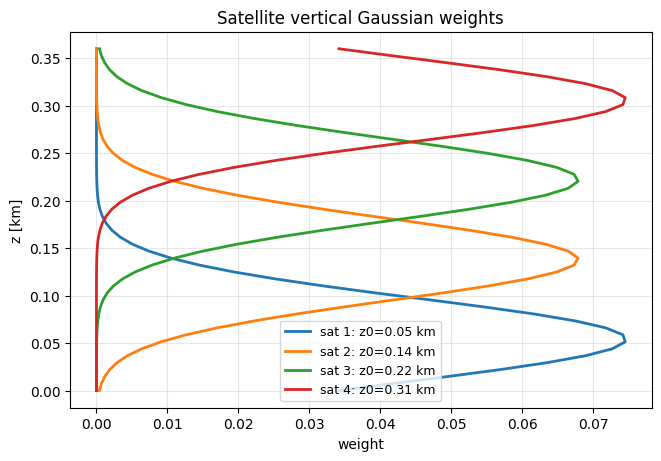

Saved: sat_weights.png


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Plot satellite vertical weighting functions sat_w[c, z]
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4.5), constrained_layout=True)

for c in range(nsat):
    ax.plot(sat_w[c, :], z/1000.0, lw=2, label=f"sat {c+1}: z0={sat_centers[c]/1000:.2f} km")

ax.set_xlabel("weight")
ax.set_ylabel("z [km]")
ax.set_title("Satellite vertical Gaussian weights")
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=9)

outname = "sat_weights.png"
fig.savefig(outname, dpi=180)
plt.show()

print(f"Saved: {outname}")

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as patches

# ============================================================
# Plot truth field + radiosonde observations (patches) overlay
# patches centered at true measurement coordinates (grid centers)
# IMPORTANT FIX: use EDGE-based extent for imshow
# saves: images_obs_rs/1_x_yrs_xx.png
# ============================================================

outdir = "images_obs_rs"
prefix = "1_x_yrs"
os.makedirs(outdir, exist_ok=True)

assert xtrue.shape[0] == nvis, "xtrue must have time dimension = nvis"
assert yrs.shape[0] == nvis,   "yrs must have time dimension = nvis"

# plotting grid (km)
x_km = x / 1000.0
z_km = z / 1000.0
dx_km = x_km[1] - x_km[0]
dz_km = z_km[1] - z_km[0]

# ---- FIX: use cell EDGE coordinates for imshow extent ----
xmin = x_km[0]  - 0.5 * dx_km
xmax = x_km[-1] + 0.5 * dx_km
zmin = z_km[0]  - 0.5 * dz_km
zmax = z_km[-1] + 0.5 * dz_km
extent = [xmin, xmax, zmin, zmax]

# ------------------------------------------------------------
# PATCH SIZE CONTROL (single knob)
#   patch_hw = 0  -> 1x1 cell size (smallest)
#   patch_hw = 1  -> 3x3 cells
#   patch_hw = 2  -> 5x5 cells
# ------------------------------------------------------------
patch_hw = 0
half_wx = patch_hw
half_wz = patch_hw

# physical patch size (km), so frames are consistent
patch_w_km = (2 * half_wx + 1) * dx_km
patch_h_km = (2 * half_wz + 1) * dz_km

# global color scale from truth fields
vmin = float(np.min(xtrue))
vmax = float(np.max(xtrue))
norm = Normalize(vmin=vmin, vmax=vmax)

ndigits = max(2, len(str(nvis - 1)))

for k in range(nvis):
    phi = xtrue[k]  # (nz, nx)

    fig, ax = plt.subplots(1, 1, figsize=(10, 3.8), constrained_layout=True)

    # background truth field
    im = ax.imshow(phi, origin="lower",
                   extent=extent,
                   aspect="auto", cmap="turbo", norm=norm)

    ax.set_title(f"Truth field + radiosonde obs overlay   snap {k+1}/{nvis}   t={t_snap[k]:.0f}s")
    ax.set_xlabel("x [km]")
    ax.set_ylabel("z [km]")

    # ------------------------------------------------------------
    # Overlay radiosonde obs as patches
    # ------------------------------------------------------------
    phi_overlay = np.full_like(phi, np.nan, dtype=np.float64)

    for irs in range(nrs):
        ix = int(rs_ix[irs])
        x0 = float(x_km[ix])  # measurement coordinate (km)

        for iv in range(nvert):
            iz = int(rs_iz[iv])
            z0 = float(z_km[iz])  # measurement coordinate (km)
            val = float(yrs[k, irs, iv])

            # fill patch into overlay array (grid-based)
            ix0 = max(0, ix - half_wx)
            ix1 = min(nx, ix + half_wx + 1)
            iz0 = max(0, iz - half_wz)
            iz1 = min(nz, iz + half_wz + 1)
            phi_overlay[iz0:iz1, ix0:ix1] = val

            # thin frame centered at true measurement coordinate
            rect = patches.Rectangle(
                (x0 - 0.5 * patch_w_km, z0 - 0.5 * patch_h_km),
                patch_w_km,
                patch_h_km,
                fill=False,
                edgecolor="black",
                linewidth=0.35,
                zorder=2000
            )
            ax.add_patch(rect)

    # draw the overlay semi-transparent
    ax.imshow(phi_overlay, origin="lower",
              extent=extent,
              aspect="auto", cmap="turbo", norm=norm, alpha=0.95)

    # indicate radiosonde columns
    for irs in range(nrs):
        ax.axvline(x_km[rs_ix[irs]], color="white", lw=0.8, alpha=0.35)

    cbar = fig.colorbar(im, ax=ax, shrink=0.95)
    cbar.set_label("φ / obs value")

    fname = f"{prefix}_{k:0{ndigits}d}.png"
    fpath = os.path.join(outdir, fname)
    fig.savefig(fpath, dpi=180)
    plt.close(fig)

    print("saved:", fpath)

print("\nDone.")


saved: images_obs_rs/1_x_yrs_00.png
saved: images_obs_rs/1_x_yrs_01.png
saved: images_obs_rs/1_x_yrs_02.png
saved: images_obs_rs/1_x_yrs_03.png
saved: images_obs_rs/1_x_yrs_04.png
saved: images_obs_rs/1_x_yrs_05.png
saved: images_obs_rs/1_x_yrs_06.png
saved: images_obs_rs/1_x_yrs_07.png
saved: images_obs_rs/1_x_yrs_08.png
saved: images_obs_rs/1_x_yrs_09.png

Done.


In [6]:
import os
import numpy as np

# ============================================================
# Save simulation truth + observation arrays for reuse
# ============================================================

outdir = "data_dyn_obs"
os.makedirs(outdir, exist_ok=True)

outfile = os.path.join(outdir, "dyn_truth_obs.npz")

np.savez_compressed(
    outfile,
    # main arrays
    xtrue=xtrue,      # (time, z, x)
    yrs=yrs,          # (time, station, vert)
    ysat=ysat,        # (time, channel, x)
    t_snap=t_snap,    # (time,)
    # metadata / operators
    rs_ix=rs_ix,      # (station,)
    rs_iz=rs_iz,      # (vert,)
    sat_w=sat_w,      # (channel, z)
    # grids (handy for plotting / reconstruction)
    x=x,
    z=z,
)

print("Saved:")
print(" ", outfile)

# quick check: list keys + shapes
tmp = np.load(outfile)
print("\nContent:")
for k in tmp.files:
    print(f"  {k:8s}  shape={tmp[k].shape}  dtype={tmp[k].dtype}")
tmp.close()

Saved:
  data_dyn_obs/dyn_truth_obs.npz

Content:
  xtrue     shape=(10, 50, 130)  dtype=float64
  yrs       shape=(10, 7, 18)  dtype=float64
  ysat      shape=(10, 4, 130)  dtype=float64
  t_snap    shape=(10,)  dtype=float64
  rs_ix     shape=(7,)  dtype=int64
  rs_iz     shape=(18,)  dtype=int64
  sat_w     shape=(4, 50)  dtype=float64
  x         shape=(130,)  dtype=float64
  z         shape=(50,)  dtype=float64
